
# TIME SERIES OF MOTOR VEHICLE FATAL COLLISIONS  IN CANADA

The data for the motor vehicle collisions on public roads in Canada can be found at  the [National collision database](https://open.canada.ca/data/en/dataset/1eb9eba7-71d1-4b30-9fb1-30cbdab7e63a).  It is a big data with more than 6 million observations. We have obtained the data for the year 1999 to 2016 and from it we've created a univariate time series data of the total monthly fatality. This notebook analyzes the data and makes forecast

# Imports

In [1]:
% load_ext autoreload
% autoreload 2

%matplotlib inline
# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Matplotlib  for data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl

# Seaborn for data visualization
import seaborn as sns
# Set font scale and style
sns.set(font_scale = 2)
sns.set_style('ticks')
plt.style.use('seaborn-white')
mpl.rcParams['font.family'] = 'serif'

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Load and Examine Data

In [2]:
df = pd.read_csv('NCDB_1999_to_2016.csv')
%time

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs


In [3]:
df.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER,C_CASE
0,1999,1,1,20,2,02,34,UU,1,5,...,06,1990,01,M,41,11,1,UU,1,752
1,1999,1,1,20,2,02,34,UU,1,5,...,01,1987,01,M,19,11,1,UU,1,752
2,1999,1,1,20,2,02,34,UU,1,5,...,01,1987,02,F,20,13,2,02,2,752
3,1999,1,1,08,2,01,01,UU,5,3,...,01,1986,01,M,46,11,1,UU,1,753
4,1999,1,1,08,2,01,01,UU,5,3,...,NN,NNNN,01,M,05,99,2,UU,3,753


In the data, each of the attribute's values with U, UU, UUU, and UUUU represent unknown.

X, XX, XXX, and XXXX represent Jurisdiction does not provide this data element. 

Q, QQ, QQQ, QQQQ represent Choice is other than the preceding values.  

N, NN, NNN, NNNN represent Data element is not applicable.

Please see the explanatory docx file at [National collision database](https://open.canada.ca/data/en/dataset/1eb9eba7-71d1-4b30-9fb1-30cbdab7e63a) for a full explanation of the attributes and their values.

In [4]:
df.shape # Dimension of the data

(6486831, 23)

## A. Select features for time series analysis

We are interested in univariate time series of the monthly fatality on public roads in Canada. For this reason, we will select few attrivutes which include the year of collision (C_YEAR), the month of collision (C_MNTH), and the fatality class (C_SEV).

In [5]:
df_selected = df[['C_YEAR','C_MNTH','C_SEV']] # Select the features

In [6]:
df_selected.to_csv('NCDB_time_series.csv', sep ='\t') # Save as csv file

## B. Replace non-numeric values with numpy nan

In [7]:
letter_list = ['U', 'UU', 'UUU', 'UUUU', 'Q', 'QQ', 'QQQ', 'QQQQ', 
               'N', 'NN', 'NNN', 'NNNN', 'X', 'XX', 'XXX', 'XXXX']
df_selected = df_selected.replace(letter_list, np.nan)

In [8]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6486831 entries, 0 to 6486830
Data columns (total 3 columns):
C_YEAR    int64
C_MNTH    object
C_SEV     int64
dtypes: int64(2), object(1)
memory usage: 148.5+ MB


## C. Missing values

In [9]:
# Percentage of missing values
missing_values = (df_selected.isnull().sum()/df_selected.shape[0])*100

# Create a dataframe of missing values
Missing_df =pd.DataFrame({'Variable': missing_values.index,
                          'Percentage of missing values': missing_values.values})
Missing_df

,Variable,Percentage of missing values
0,C_YEAR,0.000000
1,C_MNTH,0.006213
2,C_SEV,0.000000


## D. Month of the year

In [10]:
df_selected.C_MNTH.unique() # Get the unique values in C_MNTH

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, '12', nan, '01', '02', '11'],
      dtype=object)

In [11]:
df_selected.C_MNTH = pd.to_numeric(df_selected['C_MNTH'], errors = 'coerce') # Convert to numerical values

In [12]:
df_selected.C_MNTH.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., nan])

In [13]:
np.dtype(df_selected.C_MNTH) # Data type

dtype('float64')

## E. Fatality class

The fatality class is encoded as integers, where 2 represents non-fatal collisions and 1 represents fatal collisions. We will recode this as binaries (0 and 1) with 0 representing the non-fatal collisions. Our main objective is to analyze the time series of the monthly fatality

In [14]:
df_selected.C_SEV.unique()

array([2, 1])

In [15]:
df_selected.C_SEV.value_counts()

2    6378831
1     108000
Name: C_SEV, dtype: int64

In [16]:
df_selected['C_SEV']= df_selected['C_SEV'].replace(2, 0) # Replace 2 with 0

In [17]:
df_selected.C_SEV.unique()

array([0, 1])

# 2. Create a Time Series Data and Analyze

The first step in time series analysis is to put the data in a time series format. Below we use pandas pivot_table function to calculate the sum of fatality indexed by the year of collision with the columns as the month of collision. We then stack the result and form a time series data set

In [18]:
table_year= df_selected.pivot_table('C_SEV', index = 'C_YEAR', columns = 'C_MNTH', aggfunc = 'sum')
table_month= df_selected.pivot_table('C_SEV', index = 'C_MNTH', columns = 'C_YEAR', aggfunc = 'sum')

In [19]:
table_year

C_MNTH,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
C_YEAR,,,,,,,,,,,,
1999,433,482,618,438,637,645,763,730,789,648,659,756
2000,566,437,419,471,542,596,740,712,734,617,537,640
2001,408,458,451,448,498,656,594,780,588,571,573,693
2002,510,460,446,418,530,625,714,743,668,647,600,783
2003,540,347,501,430,522,605,808,760,604,615,557,581
2004,534,399,400,460,566,597,712,730,662,644,593,629
2005,538,403,472,454,595,692,638,731,589,589,590,689
2006,506,600,497,488,492,602,754,768,584,626,495,477
2007,492,492,462,501,533,593,620,672,657,620,517,609


In [20]:
# table_month.plot(figsize=(20,8), marker='o')
# plt.legend(loc = 'upper left')

In [21]:
ts = table_year.stack() # Time series data set

In [22]:
ts.head(15)

C_YEAR  C_MNTH
1999    1.0       433
        2.0       482
        3.0       618
        4.0       438
        5.0       637
        6.0       645
        7.0       763
        8.0       730
        9.0       789
        10.0      648
        11.0      659
        12.0      756
2000    1.0       566
        2.0       437
        3.0       419
dtype: int64

In [23]:
year = ts.index.get_level_values(0).values
month = ts.index.get_level_values(1).values

In [24]:
ts.index = pd.PeriodIndex(year=year, month=month, freq='M')

In [25]:
ts= pd.DataFrame({'fatalities': ts.values}, index = ts.index)

In [26]:
ts.head()

,fatalities
1999-01,433
1999-02,482
1999-03,618
1999-04,438
1999-05,637


In [27]:
ts.index = ts.index.to_timestamp()  # Convert the time index to Datetime format

In [28]:
ts.shape # Dimension of the time series

(216, 1)

In [29]:
ts.isnull().sum() # Missing values

fatalities    0
dtype: int64

We see that there are no missing values in the time series data

## A. Time Series Plot

In [30]:
def plot_timeseries(timeseries, color = None, marker= None, title = ''):
    """This function plots the time series"""
    
    # Set font size and background color
    sns.set(font_scale = 2)
    plt.style.use('ggplot')

    timeseries.plot(marker= marker, color = color,figsize=(15, 6))
    plt.xlabel('Year', fontsize = 20)
    plt.ylabel('Number of fatalities', fontsize = 20)
    plt.title(title, fontsize = 20)
    plt.grid(True)

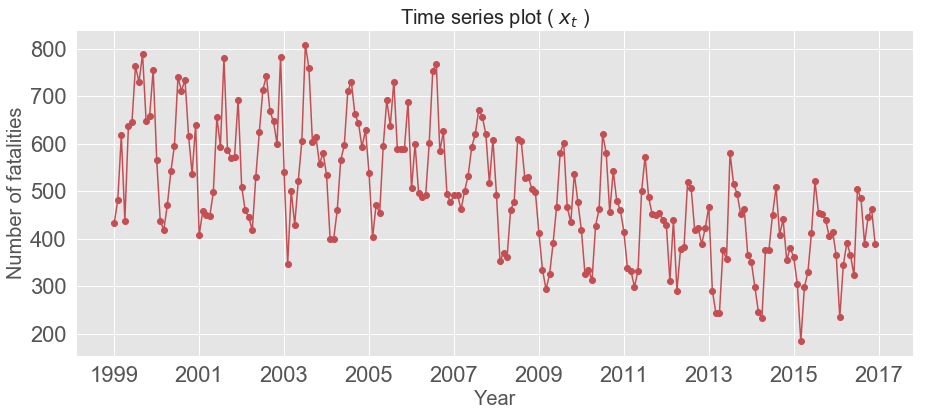

In [31]:
plot_timeseries(ts.fatalities, marker= 'o', color = 'r', title = 'Time series plot ( $x_t$ )')

## B. Stationarity Test ( Dickey-Fuller Test )

In [32]:
def plot_ts(timeseries, title = '', nlags = None):
    
    """This function plots the original time series together rolling mean and standard deviations
    and its ACF and partial ACF. It also performs the Dickey-Fuller test"""
        
    # Set font size and background color
    sns.set(font_scale = 1.5)
    plt.style.use('ggplot')
    
    gridsize = (2, 2)
    fig = plt.figure(figsize=(15, 8))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2)
    ax2 = plt.subplot2grid(gridsize, (1, 0))
    ax3 = plt.subplot2grid(gridsize, (1, 1))
    
    # Rolling statistic
    rolling_mean = timeseries.rolling(window = 24).mean()
    rolling_std = timeseries.rolling(window = 24).std()
    
    # Plot original time series and rolling mean & std
    timeseries.plot(color = 'r',marker= 'o', ax = ax1, label = 'Original')
    rolling_mean.plot(color = 'b', ax = ax1, label = 'Rolling mean')
    rolling_std.plot(color = 'g', ax = ax1, label = 'Rolling Std')
    ax1.set_xlabel('Year', fontsize = 20)
    ax1.set_ylabel('Number of fatalities', fontsize = 20)
    ax1.set_title(title,fontsize = 20)
    ax1.grid(True)
    ax1.legend(loc='best')
    
    # Plot ACF
    plot_acf(timeseries, lags = nlags, ax = ax2)
    ax2.set_xlabel('Lag', fontsize = 20)
    ax2.set_ylabel('ACF', fontsize = 20)
    ax2.set_title('Autocorrelation', fontsize = 20)
    ax2.grid(True)
    
    # Plot PACF
    plot_pacf(timeseries, lags = nlags, ax = ax3)
    ax3.set_xlabel('Lag', fontsize = 20)
    ax3.set_ylabel('PACF', fontsize = 20)
    ax3.set_title('Partial Autocorrelation', fontsize = 20)
    ax3.grid(True)
    plt.tight_layout()
    plt.show()
    
    
    # Perform Dickey-Fuller test
    adf_results = adfuller(timeseries.values) 
    print('Test statistic:', adf_results[0])
    print('p-value:',adf_results[1])
    for key, value in adf_results[4].items():
        print('Critial Values (%s): %0.6f'%(key,value))

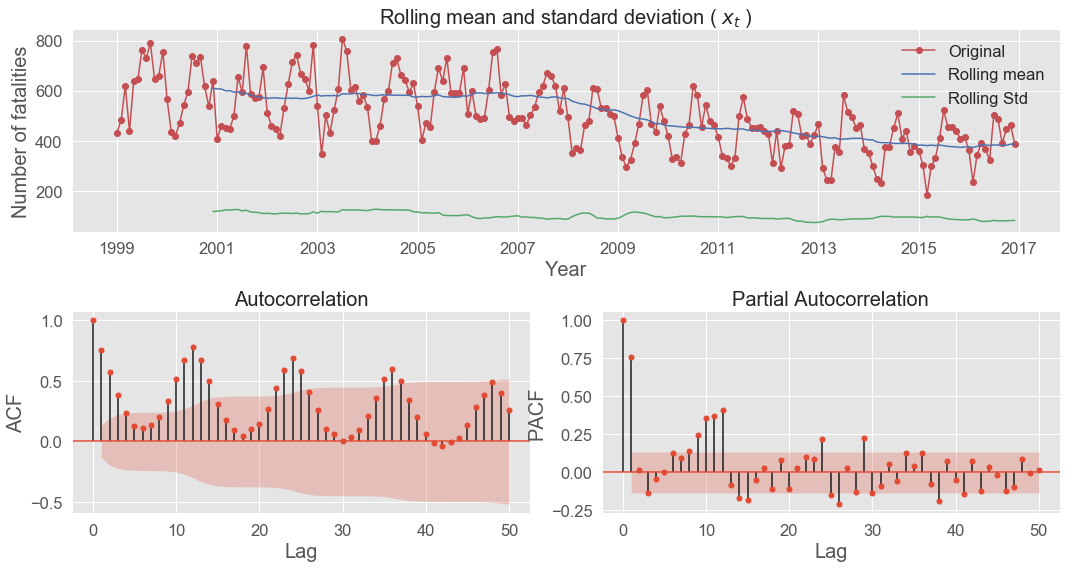

Test statistic: -1.1269984304526695
p-value: 0.7041860519218446
Critial Values (1%): -3.462818
Critial Values (5%): -2.875815
Critial Values (10%): -2.574379


In [33]:
plot_ts(ts.fatalities, title = 'Rolling mean and standard deviation ( $x_t$ )', nlags = 50)

We see that the time series is non-stationary,  because the null hypothesis cannot be rejected as the test statistic is greater than the critical values and the p-value is greater than 0.05. Another way to test for the stationarity of a time series is to plot the autocorrelation function (ACF). For a nonstationary time series the ACF will not decay quickly, whereas for a stationary time series the ACF  decays exponentially to 0 as lag increases.  The plot of ACF above shows that the time series is non-stationary.

## C. Log transformation

In [108]:
ts['fatalities_log'] = np.log(ts['fatalities'])

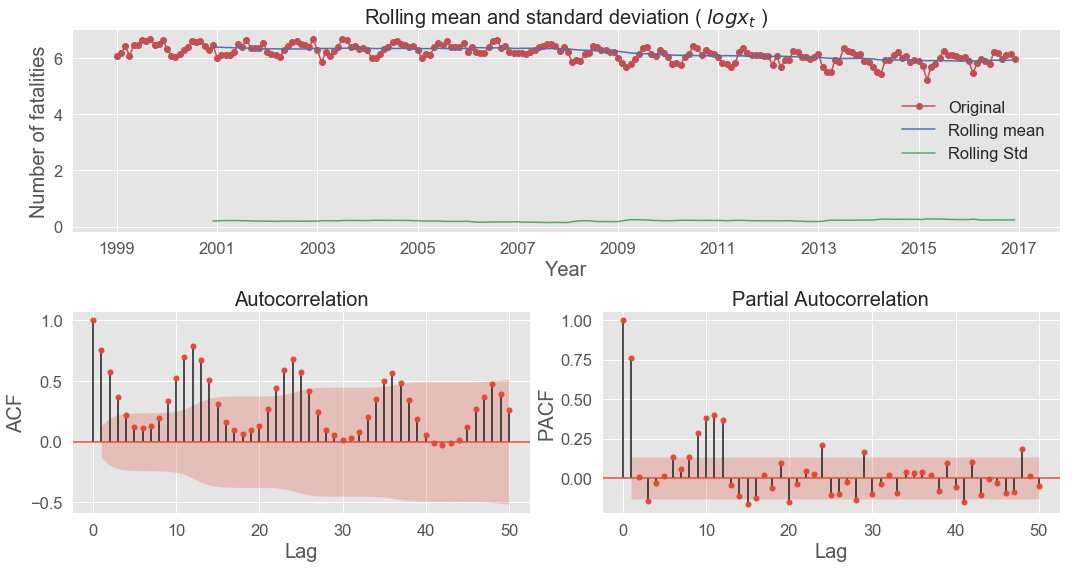

Test statistic: -0.8895539743247471
p-value: 0.7913929763598706
Critial Values (1%): -3.462818
Critial Values (5%): -2.875815
Critial Values (10%): -2.574379


In [109]:
plot_ts(ts.fatalities_log,  title = 'Rolling mean and standard deviation ( $log x_t$ )',nlags = 50)

We have checked that the log transformed data is still non-stantionary

## D. Seasonality of Log Transformed Data

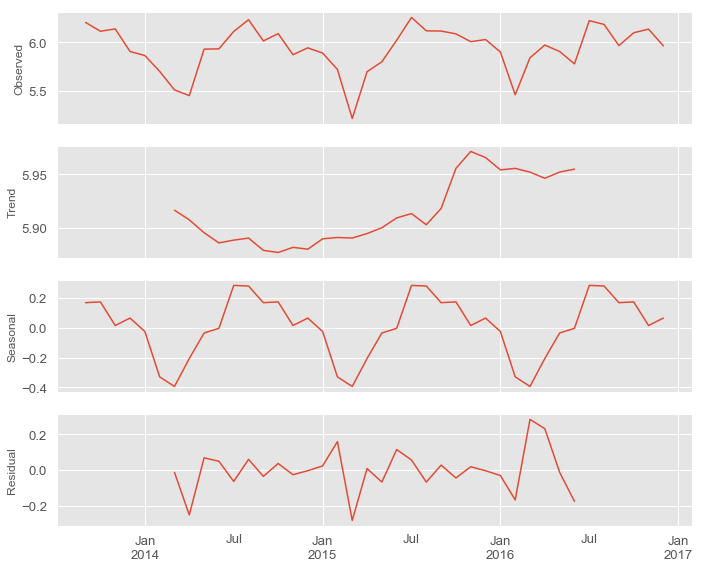

In [110]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
plt.rcParams.update({'font.size':40})
sns.set(font_scale = 1.2)
plt.style.use('ggplot')

decomposition = seasonal_decompose(ts.fatalities_log[-40:], model='additive')
decomposition.plot()
plt.show()

We have strong monthly seasonality as noted above

## E. Regular Differencing of Log Transformed Data

Differencing is one of the common methods for transforming a non-stationary time series to a  (weakly) stationary one. The first difference of a nonstationary time series  is a new time series which may be stationary. First, we take the log transformation of the time series and apply the first difference on the log transformed series

In [111]:
ts['fatalities_log_diff'] = ts['fatalities_log'] - ts['fatalities_log'].shift(1) # Apply first difference

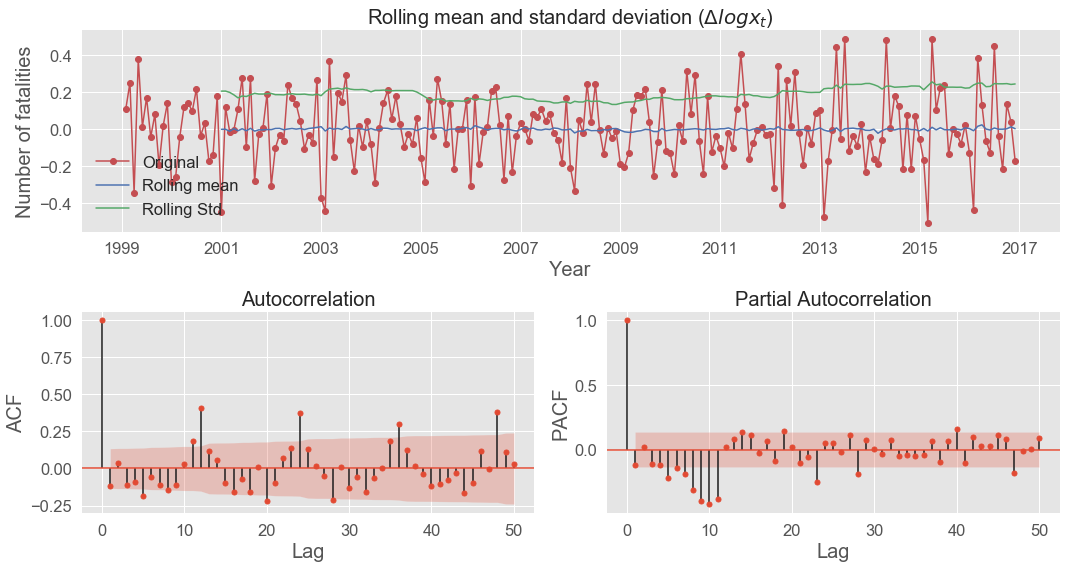

Test statistic: -16.36527065391219
p-value: 2.844764128864385e-29
Critial Values (1%): -3.462818
Critial Values (5%): -2.875815
Critial Values (10%): -2.574379


In [112]:
plot_ts(ts.fatalities_log_diff.dropna(),  title = 'Rolling mean and standard deviation ($\Delta log x_t$)',
        nlags = 50)

We see that the test statistic is signicantly less than 1$\%$ critical value  and the p-value is less than 0.05. Therefore, the time series is stationary with 99$\%$ confidence. The ACF and  PACF of the difference log transformed time series evidently decay quickly which corroborate the fact that the log transformed time series  is weakly stationary. In addition, the ACF has significant spikes at lags 12, 24, 36, indicating seasonality in the time series data

## F. Seasonal Differencing of Log Transformed Data

The analysis above suggests that we need a seasonal differencing of the time series.   Below we perform a 12-month seasonal differencing of the log transformed time series

In [113]:
ts['fatalities_log_sdiff'] = ts['fatalities_log'] - ts['fatalities_log'].shift(12)

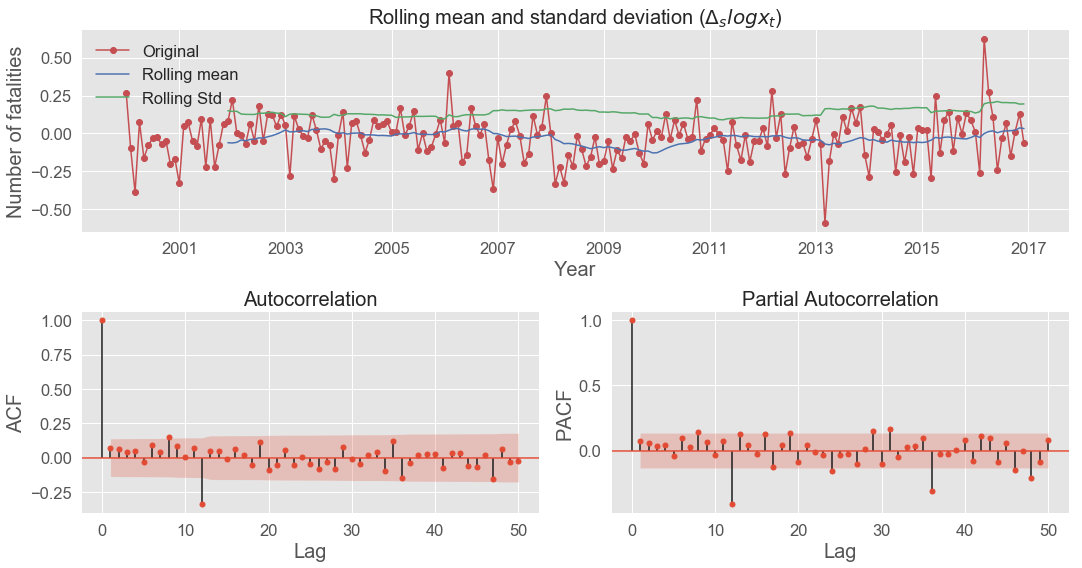

Test statistic: -3.906730893334623
p-value: 0.001985866080995015
Critial Values (1%): -3.465059
Critial Values (5%): -2.876794
Critial Values (10%): -2.574901


In [114]:
plot_ts(ts.fatalities_log_sdiff.dropna(), title = 'Rolling mean and standard deviation ($\Delta_s log x_t$)',
        nlags = 50)

From the ACF and partial ACF plots, we can make the following observations:

1. The ACF is negative and statistically significant at lag 12. In other words, the serial correlation is different from zero at the seasonal lag.

2. The partial ACFs are negative and statistically significant at lags 12, 24, 36. 

## G. Combined Regular and Seasonal Differencing of Log Transformed Data

We now compute the combined regular and seasonal diffferencing of the time series and its ACF and partial ACF

In [115]:
ts['fatalities_log_sddiff'] = ts['fatalities_log_sdiff'] - ts['fatalities_log_sdiff'].shift(1)

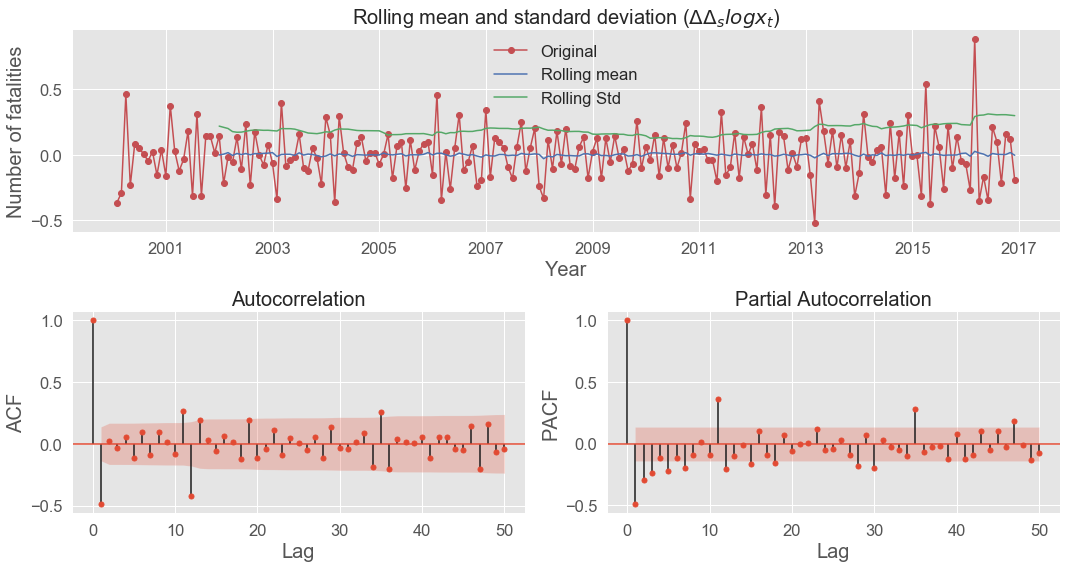

Test statistic: -4.801567622937907
p-value: 5.401164216087464e-05
Critial Values (1%): -3.465812
Critial Values (5%): -2.877123
Critial Values (10%): -2.575077


In [116]:
plot_ts(ts.fatalities_log_sddiff.dropna(), 
        title = 'Rolling mean and standard deviation ($\Delta \Delta_s log x_t$)',
        nlags = 50)

From the plots above, we can identify the orders of the regular and seasonal moving averages. For instance, we can see that the autocorrelation appears to be insignifcant at lags 24 and 36, whereas it has a negative spike at lag 12 after which the seasonal autocorrelation cuts off. This would suggest that the data could be modeled with a moving average model applied to the 12-month period. 

To identify the moving average of the regular time series, we look at patterns between successive months. We see that there is a signifcant autocorrelation a lag 1, after which the autocorrelation seems to cut off. This would indicate a first order moving average for the regular time series.

# 3. Model Fitting and Diagnostic Checking

## A. Training and  Test  Sets


As we saw above, we used the entire observation of the data set to identify the model. However, we would like to show how to use the model to make short-term forecasts. Therefore, we must split the data set into training and test set; we have chosen the test set as the last three year's observations (i.e. 2013-2016).

In [117]:
train_start,train_end = '1999-01-01','2015-12-31'
test_start,test_end = '2016-01-01','2016-12-01'
X_train = ts['fatalities_log'][train_start:train_end].dropna()
X_test = ts['fatalities_log'][test_start:test_end].dropna()

## B. SARIMAX Model

We now build a seasonal autoRegressive integrated moving average with eXogenous (SARIMAX) regressors model

In [118]:
model = SARIMAX(X_train, trend ='n', order=(0, 1, 1), seasonal_order=(0, 1, 1, 12),
               enforce_stationarity=False, enforce_invertibility=False)

results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     fatalities_log   No. Observations:                  204
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 133.272
Date:                            Sat, 13 Jul 2019   AIC                           -260.545
Time:                                    16:27:03   BIC                           -251.017
Sample:                                01-01-1999   HQIC                          -256.681
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8569      0.043    -19.719      0.000      -0.942      -0.772
ma.S.L12      -0.7958      0.053   

## C. Diagnostic Plots of the Residuals

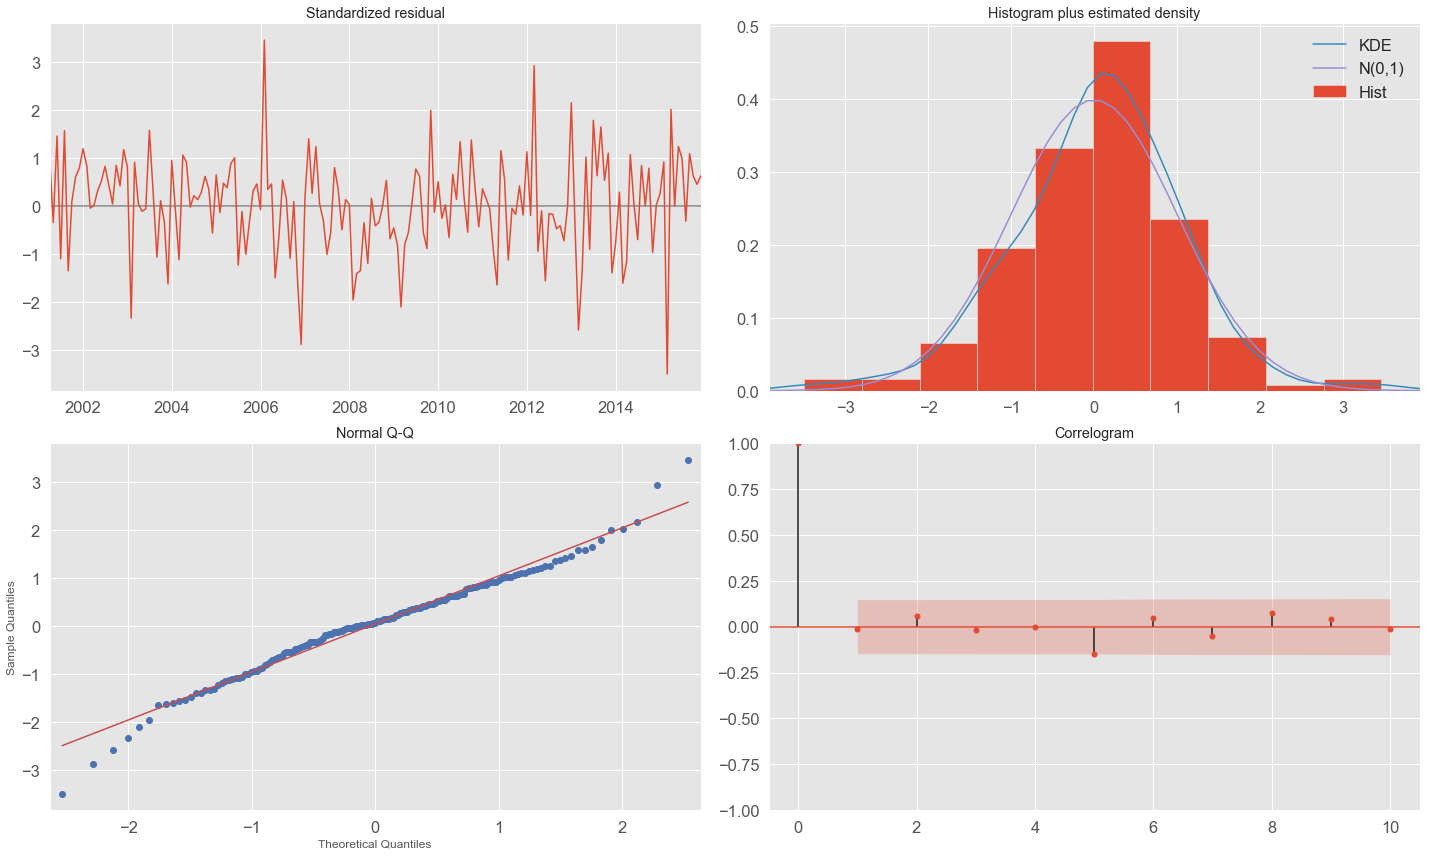

In [119]:
results.plot_diagnostics(figsize=(20,12))
# plt.grid(True)
plt.tight_layout()

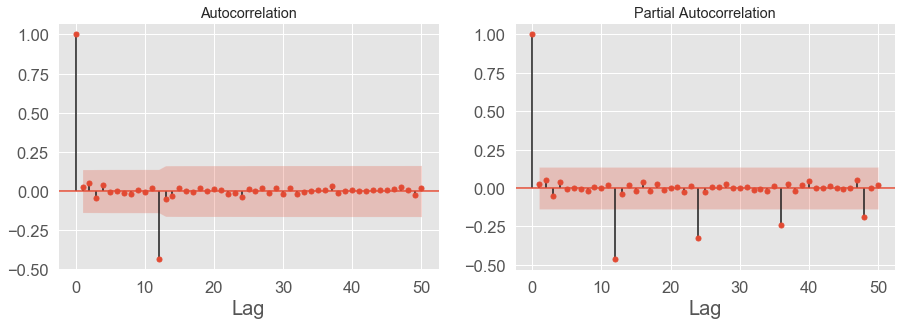

In [120]:
res = results.resid # Residuals

# Set figure and font sizes
sns.set(font_scale = 1.5)
plt.style.use('ggplot')

gridsize = (2, 2)
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot2grid(gridsize, (1, 0))
ax2 = plt.subplot2grid(gridsize, (1, 1))


nlags = 50
# Plot ACF
plot_acf(res, lags = nlags, ax = ax1)
ax1.set_xlabel('Lag', fontsize = 20)
ax1.grid(True)

# Plot PACF
plot_pacf(res, lags = nlags, ax = ax2)
ax2.set_xlabel('Lag', fontsize = 20)
ax2.grid(True)
plt.show()

From the above residual analysis, we see that the model looks good up to lag 10 beyond which the ACF and partial ACF develop a spike at the season lag, 12. 

Below, we look at other self-made  diagnostic plots of the residuals

Text(0,0.5,'Residual')

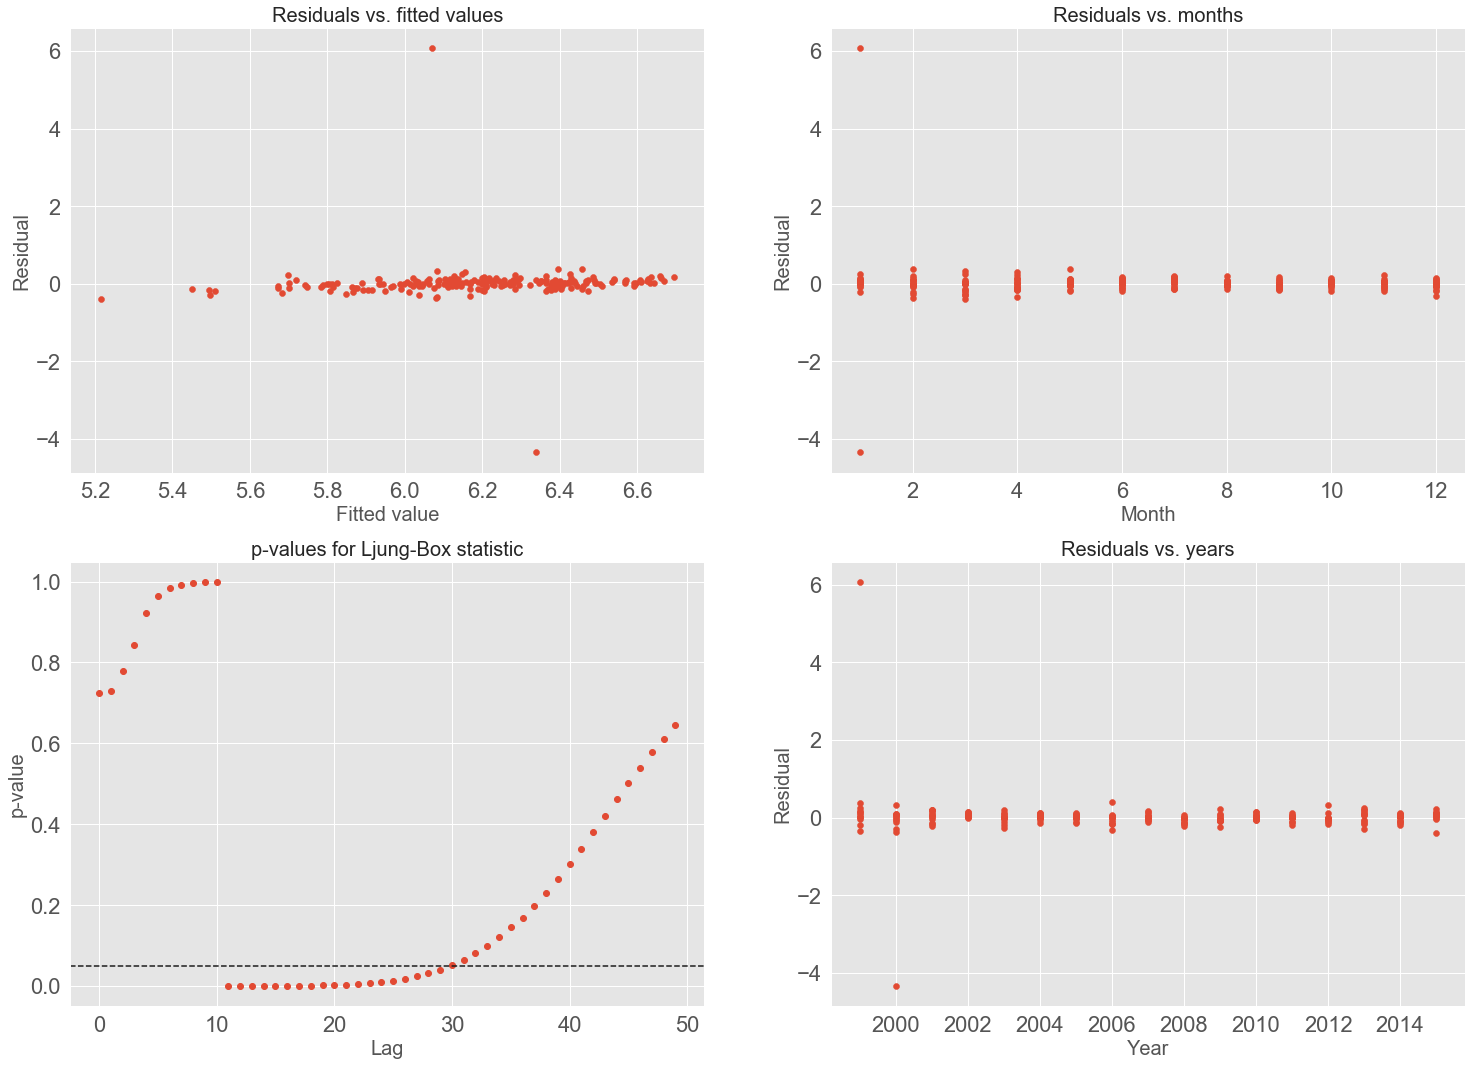

In [121]:
# Set figure size
gridsize = (2,2)

fig = plt.subplots(figsize = (25,18))
sns.set(font_scale = 2)
plt.style.use('ggplot')

ax1 = plt.subplot2grid(gridsize, (0,0))
ax2 = plt.subplot2grid(gridsize, (0,1))
ax3 = plt.subplot2grid(gridsize, (1,0))
ax4 = plt.subplot2grid(gridsize, (1,1))

# Make plots
ax1.scatter(X_train.values, res.values)
ax2.scatter(X_train.index.month, res.values)
ax3.plot(acorr_ljungbox(res.values, lags = 50)[1], 'o')
ax3.axhline(y=0.05,linestyle= '--', color = 'k')
ax4.scatter(X_train.index.year, res.values)

# Plot labels
ax1.set_xlabel('Fitted value', fontsize = 20)
ax1.set_title('Residuals vs. fitted values', fontsize = 20)
ax1.set_ylabel('Residual', fontsize = 20)
ax2.set_xlabel('Month', fontsize = 20)
ax2.set_ylabel('Residual', fontsize = 20)
ax2.set_title('Residuals vs. months', fontsize = 20)
ax3.set_xlabel('Lag', fontsize = 20)
ax3.set_ylabel('p-value', fontsize = 20)
ax3.set_title('p-values for Ljung-Box statistic', fontsize = 20)
ax4.set_xlabel('Year', fontsize = 20)
ax4.set_title('Residuals vs. years', fontsize = 20)
ax4.set_ylabel('Residual', fontsize = 20)

From the above diagnostic plots, we see that something unusual happened in January 1999 and 2000 due to significant outliers. A careful inspection of the data shows that most fatal collision happpned in those years. The plot of the p-value vs. lag of the Ljung–Box Q test shows a discontinuity at lag 12. The model seems to work best up to lag 10 as we noted above.  We  have also tried other transformations and models but nothing seems to do a better job than the model we've have built. In the following, we now make forecast based on the SARIMAX model.

## D. Performance Metric

In [122]:
def mae(y_test,y_pred):
    """Mean absolute error."""
    
    mae = np.abs(y_test-y_pred).mean() 
    return mae

def rmse(y_test,y_pred):
    """Root mean squared error."""
    
    rmse = np.sqrt( np.mean((y_test-y_pred)**2))
    return rmse

def r_squared(y_test,y_pred):
    """r squared (coefficient of determination)."""
    
    mse = np.mean((y_test-y_pred)**2) # mean squared error
    var = np.mean((y_test - np.mean(y_test))**2) # sample variance 
    r_squared = 1-mse/var 
    
    return r_squared

## Model Forecasting

In [123]:
X_pred = results.predict(test_start,test_end)
print('SARIMAX model MAE:{}'.format(mae(X_test,X_pred)))

SARIMAX model MAE:0.12990284228387727


In [124]:
df_af = pd.DataFrame({'Actual':np.exp(X_test),'Forecast':np.exp(X_pred), 'Residual':np.exp(X_test-X_pred)})

In [125]:
df_af

,Actual,Forecast,Residual
2016-01-01,365.0,362.275592,1.007520
2016-02-01,235.0,287.631242,0.817018
2016-03-01,344.0,254.114525,1.353720
2016-04-01,392.0,263.447383,1.487963
2016-05-01,367.0,340.142810,1.078959
2016-06-01,323.0,380.219787,0.849509
2016-07-01,504.0,483.946003,1.041439
2016-08-01,485.0,467.681862,1.037030
2016-09-01,390.0,413.338951,0.943536
2016-10-01,445.0,412.629489,1.078449


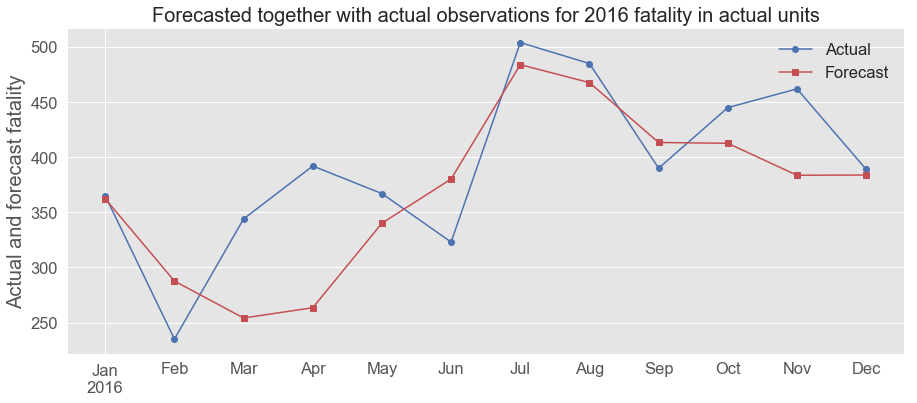

In [126]:
sns.set(font_scale = 1.5)
plt.style.use('ggplot')

df_af['Actual'].plot(figsize=(15,6), marker = 'o', color = 'b')
df_af['Forecast'].plot(figsize=(15,6), marker = 's', color = 'r')
plt.ylabel('Actual and forecast fatality', fontsize = 20)
plt.title('Forecasted together with actual observations for 2016 fatality in actual units', fontsize = 20)
plt.grid(True)
plt.legend()

We see that forecast relatively captured the actual values, however the forecast suffers immensely from extreme outliers, therefore the model can be improved by resolving this isssue.